In [1]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Download inception weights

In [2]:
## Create a folder to download our data
data_folder = 'data'
if not os.path.exists(data_folder):
    print("Creating data folder...")
    os.mkdir(data_folder)
    
## Download data
download_command = '''wget \
--no-check-certificate \
https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'''

if not os.path.exists(data_folder + '/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'):
    print("Downloading data...")
    os.system(download_command)

### Load inception model and set weights

In [3]:
pre_trained_model = InceptionV3(input_shape = (150,150, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights('data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

for layer in pre_trained_model.layers:
    layer.trainable = False
    
pre_trained_model.summary()

W0805 20:50:34.117532 140152025937728 deprecation.py:506] From /home/elder/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Grab one of the last layers and add a few layers of our own

In [4]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


In [5]:
from tensorflow.keras.optimizers import RMSprop

## Flatten the ouput of the Inception network
x = layers.Flatten()(last_output)
## Add a fully conencted layer with 1024 hidden units and ReLu activation
x = layers.Dense(1024, activation = 'relu')(x)
## Add a droput rate of 0.2
x = layers.Dropout(0.2)(x)
## Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer= RMSprop(lr=0.0001),
              loss = 'binary_crossentropy',
              metrics =['acc']        
             )

W0805 20:50:41.031649 140152025937728 deprecation.py:323] From /home/elder/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Download larger Cats vs. Dogs dataset

In [6]:
## Create a folder to download our data
data_folder = 'data'
if not os.path.exists(data_folder):
    print("Creating data folder...")
    os.mkdir(data_folder)
    
## Download data
download_command = '''wget \
--no-check-certificate \
https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \-O data/cats-and-dogs-filtered.zip'''

if not os.path.exists(data_folder + '/cats-and-dogs-filtered.zip'):
    print("Downloading data...")
    os.system(download_command)

In [7]:
## Unzip
base_dir = 'data/cats_and_dogs_filtered/'
zip_ref = zipfile.ZipFile(data_folder + '/cats-and-dogs-filtered.zip','r')
zip_ref.extractall(data_folder)
zip_ref.close()

In [8]:
train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Train model

In [9]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 15s - loss: 0.4928 - acc: 0.7590 - val_loss: 0.1661 - val_acc: 0.9460
Epoch 2/20
100/100 - 12s - loss: 0.3632 - acc: 0.8370 - val_loss: 0.3569 - val_acc: 0.9160
Epoch 3/20
100/100 - 12s - loss: 0.3301 - acc: 0.8530 - val_loss: 0.3604 - val_acc: 0.9300
Epoch 4/20
100/100 - 12s - loss: 0.3267 - acc: 0.8630 - val_loss: 0.2175 - val_acc: 0.9550
Epoch 5/20
100/100 - 12s - loss: 0.2982 - acc: 0.8705 - val_loss: 0.3153 - val_acc: 0.9430
Epoch 6/20
100/100 - 12s - loss: 0.3176 - acc: 0.8695 - val_loss: 0.2674 - val_acc: 0.9560
Epoch 7/20
100/100 - 12s - loss: 0.3135 - acc: 0.8695 - val_loss: 0.3984 - val_acc: 0.9400
Epoch 8/20
100/100 - 12s - loss: 0.3016 - acc: 0.8775 - val_loss: 0.5377 - val_acc: 0.9260
Epoch 9/20
100/100 - 12s - loss: 0.2748 - acc: 0.8835 - val_loss: 0.4963 - val_acc: 0.9380
Epoch 10/20
100/100 - 12s - loss: 0.2740 - acc: 0.8880 - val_loss: 0.3433 - val_acc: 0.9520
Epoch 11/20
100/100 - 12s - loss: 0.2798 - acc: 0.8875 - val_loss: 0.5157 - val_acc: 0.93

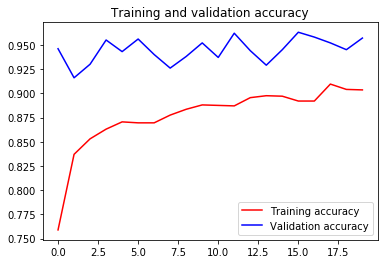

In [11]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.show()